## Benchmarking bounded sub-optimal A*

Цель - провести экспериментальное исследование и анализ алгоритма WA* с разными значениями параматера w (фактор субоптимальности). Неформально - нам нужен ответ на вопрос насколько сильно мы теряем в качестве решения (длине пути) и при этом приобретаем в вычислительной эффективности (решение ищется быстрее).


Реализовать алгоритм WA* для задачи планирования траектории на сетчатых графах (grids) 1.1 Связность графа - 8-connected (разрешены ортогональные и диагональные переходы). Режим cutcorners - на ваше усмотрение.

1.2 Эвристика - Octile distance

1.3 Без перераскрытий

Провести эмпирическое исследование и сравнение WA* vs A* 2.1 Карты и задания - из коллекции Movingai

2.2 Минимальное число различных карт - 3 шт (карты должны быть визуально различными, из разных топологий, например город, лабиринт, комнаты/рандом

2.3 На каждую карту - минимум по 100 заданий различной (!) сложности

2.4 Для WA* необходимо использовать min 5 различных значений фактора субоптимальность, например 1.05, 1.1, 1.5, 2, 3, 5

По результатам исследования построить графики/таблицы и провести их анализ (написать текстовый отчет) 3.1 Обязательно описывать experimental setup: какие карты выбраны (картинки), почему, по сколько заданий на карту, как задания генерировались/выбирались из базы заданий, какие метрики отслеживались.

3.2 Графики/таблицы должны быть составлены таким образом, чтобы было визуально легко осуществлять side-by-side сравнение различных алгоритмов

3.3 Оси на графиках должны быть подписаны. Текстом в ячейке должно быть объяснено, что изображено на графике/таблице, как читать этот график/таблицу.

3.4 Каждый график должен быть прокомментирован (какие выводы мы можем сделать, глядя на него).

3.5 Должны быть отмечены какие-то интересные моменты/нестандартные (неожидаемые) тренды (при наличии). Должно быть дано объяснение, хотя бы на уровне гипотезы, почему такие моменты возникают.

3.6 Должен быть сделан общий high-level вывод по результатам анализа

### Тесты

Чтобы протестировать алгоритм, рассмотрим карты из датасета [MovingAI](https://movingai.com/benchmarks/grids.html). Каждый тест будет включать поиск кратчайшего пути от заданного начального узла до конечного узла с использованием неоптимального алгоритма A*, эвристики октиля и различных весовых значений.

Измерим несколько ключевых показателей для оценки производительности алгоритма:
- Длина пути
- Время выполнения
- Размер дерева поиска
- Корректность длины пути

Какие карты будем использовать:
- Карта DAO: большое пустое пространство, мало препятствий и почти прямые пути.
- Карта Maze: небольшое пустое пространство, много препятствий и ветвей со сложной топологией.
- Карта Street: среднее пустое пространство, препятствия обычно представляют собой линейные сегменты, пути представляют собой сглаженные полигональные цепи.

### Вывод
Результаты сравнительного анализа показывают, что ограниченный субоптимальный алгоритм A* работает конкурентоспособно по сравнению с исходным A* с точки зрения качества решения и эффективности времени выполнения. Он оказался хорошим подходом для решения задач оптимизации, особенно в сценариях, где важна скорость поиска, а оптимальность решения стоит на втором месте. Способность алгоритма предоставлять достаточно хорошие решения в пределах ограниченной субоптимальности делает его пригодным для приложений реального времени, где приемлемы приближенные решения.

In [1]:
import json
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw

%matplotlib inline

In [2]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]
    
    def edge_cut(self, i: int, j: int, di: int, dj: int):
        """
        Checks if the diagonal move (i+di, j+dj) has no edge cuts

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.
        di : int
            Offset for the row.
        dj : int
            Offset for the column.

        Returns
        ----------
        bool
            True if there are no edge cuts, False otherwise
        """
        return self.traversable(i + di, j) and self.traversable(i, j + dj)

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 4-connected, allowing moves only in cardinal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0), (1,1), (1,-1), (-1,1), (-1,-1))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj) and self.edge_cut(i, j, dx, dy):
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [3]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '@', 'O', 'T', 'S', 'W', '#' for obstacles and
    '.', 'G' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('#' for obstacles and '.' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.replace(" ", "").split("\n")

    terrain_legend = {
        '.': 0,
        'G': 0,
        '@': 1,
        'O': 1,
        'T': 0,
        'S': 1,
        'W': 1,
        '#': 1
    }
    cells = np.array(
        [[terrain_legend[char] for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

In [4]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal moves are supported).
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1: # Diagonal move
        return 1.414213
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal moves are supported.")

In [5]:
class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
        w: Optional[float] = 1
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        w : float
            weight value of the heuristic (always equal 1 for default A*)
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        self.w = w
        if f is None:
            self.f = self.g + w * h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return (self.i, self.j) == (other.i, other.j)

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

In [6]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = dict()  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while True:
            if not self._open:
                return None
            
            best_node = heappop(self._open)
            
            if self.was_expanded(best_node): # node was expanded
                self._enc_open_duplicates += 1
                continue

            return best_node

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

In [7]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        current_node = ast.get_best_node_from_open()

        # in lazy impementation we may expand all nodes, but duplicates are still exists
        if current_node is None:
            break

        if (current_node.i, current_node.j) == (goal_i, goal_j):
            return True, current_node, steps, len(ast), ast.opened, ast.expanded
        
        for neighbor_i, neighbor_j in task_map.get_neighbors(current_node.i, current_node.j):
            neighbor_g = current_node.g + compute_cost(current_node.i, current_node.j, neighbor_i, neighbor_j)
            neighbor_h = heuristic_func(neighbor_i, neighbor_j, goal_i, goal_j)  
            neighbor_node = Node(neighbor_i, neighbor_j, g=neighbor_g, h=neighbor_h, parent=current_node)
            
            if not ast.was_expanded(neighbor_node):
                ast.add_to_open(neighbor_node)
        
        ast.add_to_closed(current_node)
  

    return False, None, steps, len(ast), None, ast.expanded

In [8]:
def wastar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
    weight: float
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the WA* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.
    weight : float
        Sub-optimal factor of WA*.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    if weight < 1:
        raise ValueError("Heuristic weight must be >= 1")

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        current_node = ast.get_best_node_from_open()

        # in lazy impementation we may expand all nodes, but duplicates are still exists
        if current_node is None:
            break

        if (current_node.i, current_node.j) == (goal_i, goal_j):
            return True, current_node, steps, len(ast), ast.opened, ast.expanded
        
        for neighbor_i, neighbor_j in task_map.get_neighbors(current_node.i, current_node.j):
            neighbor_g = current_node.g + compute_cost(current_node.i, current_node.j, neighbor_i, neighbor_j)
            neighbor_h = heuristic_func(neighbor_i, neighbor_j, goal_i, goal_j)  
            neighbor_node = Node(neighbor_i, neighbor_j, g=neighbor_g, h=neighbor_h, w=weight, parent=current_node)
            
            if not ast.was_expanded(neighbor_node):
                ast.add_to_open(neighbor_node)
        
        ast.add_to_closed(current_node)
  

    return False, None, steps, len(ast), None, ast.expanded

In [9]:
def octile_distance(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the Octile(diagonal) distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    float
        Octile distance between the two cells.
    """
    dx = abs(i1 - i2)
    dy = abs(j1 - j2)
    card_cost = 1
    diag_cost = 1.41423
    return card_cost * max(dx, dy) + (diag_cost - card_cost) * min(dx, dy)

In [10]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw(
    grid_map: Map,
    start: Optional[Node] = None,
    goal: Optional[Node] = None,
    path: Optional[Iterable[Node]] = None,
    nodes_discovered: Optional[Iterable[Node]] = None,
    nodes_expanded: Optional[Iterable[Node]] = None,
    nodes_reexpanded: Optional[Iterable[Node]] = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded/re-expanded nodes.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[Node], Optional[Node]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[Node]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[Node]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[Node]]
        Nodes that were expanded during the search process.
    nodes_reexpanded : Optional[Iterable[Node]]
        Nodes that were re-expanded during the search process.
    """
    scale = 5
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
        (nodes_reexpanded, (255, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

In [11]:
def make_path(goal: Node) -> Tuple[List[Node], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : Node
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[Node], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [12]:
def read_task_from_file(
    path: str,
) -> List[Tuple[npt.NDArray, int, int, int, int, float]]:
    """
    Reads map, start/goal positions, and true value of path length between the given start and goal from a file.

    Parameters
    ----------
    path : str
        Path to a file with the pathfinding problem instance.

    Returns
    -------
    cells : npt.NDArray
        Matrix of grid map cells.
    start_i, start_j : int, int
        Position of the start cell in the grid.
    goal_i, goal_j : int, int
        Position of the goal cell in the grid.
    length : float
        True value of the path's length between the given start and goal.
    """
    cells = None
    
    with open(path) as map_file:
        type = next(map_file)
        height = int(next(map_file).split()[1]) # <- "height ***"
        width = int(next(map_file).split()[1]) # <- "width ***"

        # Read the map section
        map = next(map_file)
        map_lines = [next(map_file) for _ in range(height)]
        map_str = "\n".join(map_lines)
        cells = convert_string_to_cells(map_str)

    path = path.split('/') # expected path = .../data/*-map/*.map
    path[-2] = path[-2].replace('map', 'scen')
    path[-1] += '.scen'
    path = '/'.join(path) # -> expected outup path = .../data/*-scen/*.map.scen
    
    data = []
    with open(path) as task_file:
        for line in task_file.readlines()[1:]:    # 0	maze512-1-0.map	512	512	477	130	476	131	2.00000000
            difficulty, name, h, w, start_i, start_j, goal_i, goal_j, lenght = line.split()
            data.append([cells, int(start_j), int(start_i), int(goal_j), int(goal_i), float(lenght)])  # cells, start_i, start_j, goal_i, goal_j, length

    return data

In [13]:
def simple_test(search_function: Callable, task: Union[int, None], data_path: str, *args):
    """
    Function `simple_test` runs `search_function` on one task. Use a number to choose a specific debug task
    on a simple map, or use None to select a random task from this pool. The function displays:
     - 'Path found!' and some statistics if a path was found.
     - 'Path not found!' if a path was not discovered.
     - 'Execution error' if an error occurred during the execution of the search_function.
    In the first case, the function also provides a visualization of the task.

    Parameters
    ----------
    search_function : Callable
        Implementation of the search method.
    task : int | None
        A number from 0 to 24 to choose a specific debug task on a simple map,
        or None to select a random task from this pool.
    *args
        Additional arguments passed to the search function.
    """
    
    task_list = read_task_from_file(data_path)
    
    cells, start_i, start_j, goal_i, goal_j, length = task_list[task]
    
    task_map = Map(cells)
    start = Node(start_i, start_j)
    goal = Node(goal_i, goal_j)
    
    try:
        (
            found,
            end_node,
            number_of_steps,
            search_tree_size,
            *other_results,
        ) = search_function(task_map, start.i, start.j, goal.i, goal.j, *args)

        if found:
            path, path_length = make_path(end_node)
            correct = int(path_length) == int(length)
            draw(task_map, start, goal, path, *other_results)
            print(
                f"Path found! Length: {path_length}. Search tree size: {search_tree_size}. Number of steps: {number_of_steps}. Correct: {correct}"
            )
        else:
            print("Path not found!")
        return

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()

In [14]:
from os import listdir
import time
def massive_test(search_function, data_path, seed, *args) -> Dict:
    """
    The `massive_test` function runs the `search_function` on a set of different tasks
    (for example, from the directory `data/`) using *args as optional arguments.
    For every task, it displays a short report:
     - 'Path found!' along with some statistics if a path was found.
     - 'Path not found!' if a path wasn't found.
     - 'Execution error' if an error occurred during the execution of the search_function.

    The function returns a dictionary containing statistics with the following keys:
     - "corr" — correctness of each path length (True/False).
     - "len" — the length of each path (0.0 if a path wasn't found).
     - "st_size" — the size of the resultant search tree for each task.
     - "steps" — the number of algorithm steps for each task.

    Parameters
    ----------
    search_function : Callable
        The implemented search method.
    data_path : str
        Path to the directory containing tasks.
    num_of_tasks : int
        The number of tasks to be used for evaluation.

    Returns
    -------
    stat : Dict
        A dictionary containing statistics.

    """
    stat = {
        "corr": [],
        "len": [],
        "st_size": [],
        "steps": [],
        "time": [],
        "map_name": []
    }

    num_of_tasks = 100

    np.random.seed(seed)

    l = {0: 'dao', 1: 'maze', 2: 'street'}
    task_folder = f"{data_path}{l[seed % 3]}-map/"

    for filename in listdir(task_folder):
        if not filename.endswith('.map'):
            continue

        task_list = read_task_from_file(task_folder + filename) 
        n = len(task_list)

        task_id = 0
        random_tasks = sorted(np.random.randint(0, n, size=num_of_tasks))
        for i in random_tasks:
            task_id += 1
            cells, start_i, start_j, goal_i, goal_j, length = task_list[i]
            
            task_map = Map(cells)
            try:
                start_time = time.time()
                (
                    found,
                    end_node,
                    number_of_steps,
                    search_tree_size,
                    *other_results,
                ) = search_function(task_map, start_i, start_j, goal_i, goal_j, *args)
                end_time = time.time()
                if found:
                    _, path_length = make_path(end_node)
                    correct = int(path_length) == int(length)

                    # print(
                    #     f"Task: #{task_id}. Path found! Length: {path_length}. Search tree size: {search_tree_size}. "
                    #     f"Number of steps: {number_of_steps}. Correct: {correct}"
                    # )

                    stat["len"].append(path_length)
                    stat["corr"].append(correct)
                else:
                    print(f"Task: #{task_id}. Path not found!")
                    stat["len"].append(0.0)
                    stat["corr"].append(False)

                stat["st_size"].append(search_tree_size)
                stat["steps"].append(number_of_steps)
                stat["time"].append(end_time - start_time)
                stat["map_name"].append(filename)
            except Exception as e:
                print(f"Execution error: {e}")
                traceback.print_exc()
            
        break

    return stat

In [15]:
def lt_g_max(self, other):
    if self.f == other.f:
        return self.g > other.g
    return self.f < other.f


def lt_g_min(self, other):
    if self.f == other.f:
        return self.g < other.g
    return self.f < other.f

Node.__lt__ = lt_g_max
# Node.__lt__ = lt_g_min

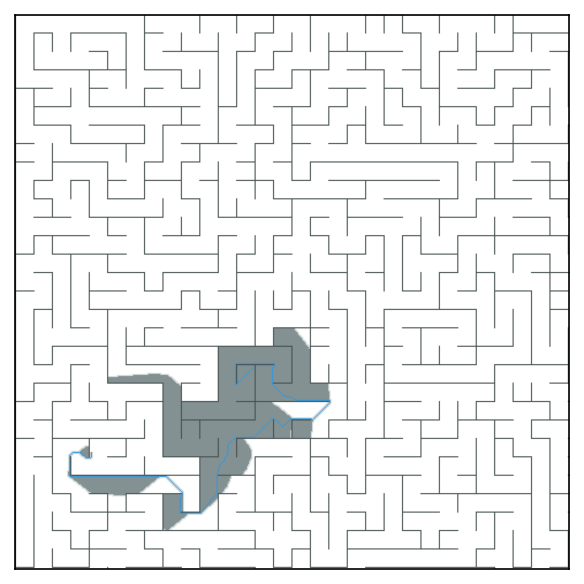

Path found! Length: 545.5756070000007. Search tree size: 15877. Number of steps: 13704. Correct: False
CPU times: user 1.6 s, sys: 144 ms, total: 1.74 s
Wall time: 1.58 s


In [16]:
%time res = simple_test(wastar, 1337, 'data/maze-map/maze512-16-0.map', octile_distance, SearchTreePQD, 2)

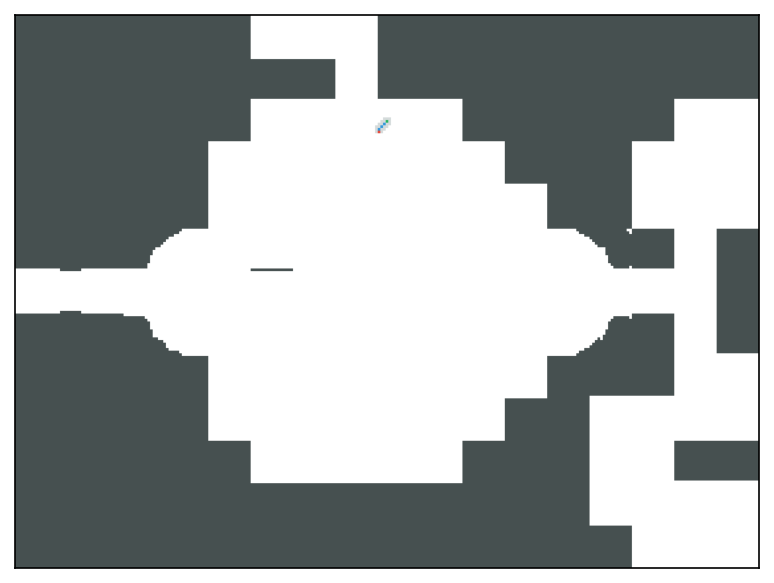

Path found! Length: 5.242639. Search tree size: 29. Number of steps: 5. Correct: True
CPU times: user 456 ms, sys: 79.3 ms, total: 535 ms
Wall time: 371 ms


In [17]:
%time res = simple_test(astar, 15, 'data/dao-map/arena2.map', octile_distance, SearchTreePQD)

In [18]:
# wastar_statistic = {
#     1: [],
#     1.05: [],
#     1.1: [],
#     1.5: [],
#     2: [],
#     3: [],
#     5: []
# }
# for weight in wastar_statistic.keys():
#     for i in range(3):
#         wastar_statistic[weight].append(massive_test(wastar, 'data/', i, octile_distance, SearchTreePQD, weight))
    
    
# with open("stat/wastar_stat.txt", 'w') as file:
#     file.write(json.dumps(wastar_statistic))

In [19]:
wastar_statistic = json.loads(open("stat/wastar_stat.txt", "r").read())

wastar_statistic["1"][0].keys()

dict_keys(['corr', 'len', 'st_size', 'steps', 'time', 'map_name'])

### Результаты

Копипаста закончилась, к этому моменту мы собрали всю необходимую статистику, и можно приступить к анализу

Посчитаем процент верных путей:

<BarContainer object of 7 artists>

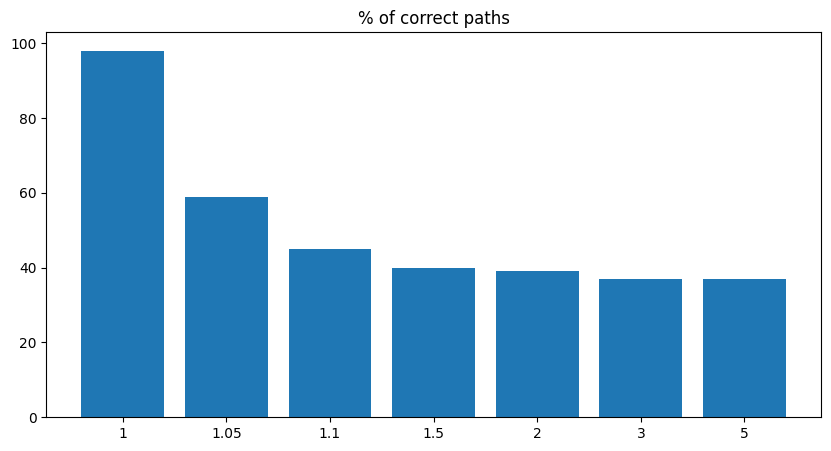

In [20]:
NUMBER_OF_TASKS = 100
NUMBER_OF_TRIALS = 3

correct_paths = {key: 0 for key in wastar_statistic.keys()}

for i in range(NUMBER_OF_TRIALS):
    for j in range(NUMBER_OF_TASKS):
        for w in correct_paths.keys():
            correct_paths[w] += wastar_statistic[w][i]["corr"][j]
        
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_title("% of correct paths")
ax.bar(correct_paths.keys(), [value//NUMBER_OF_TRIALS for value in correct_paths.values()])

WA* с весом 1 <=> Default A*, поэтому мы ожидаем, что он будет на 100% правильным.

По мере увеличения веса эвристической функции количество правильных ответов уменьшается. Это неудивительно — по мере увеличения минимального порога вероятность получения оптимального решения из первого результата сопоставления уменьшается.

Все алгоритмы с весом 1,5+ имеют примерно 40% правильных длин. Это происходит из-за того, что существует достаточно прямых путей без препятствий, а первый путь сопоставления является правильным путем.

### Длины путей

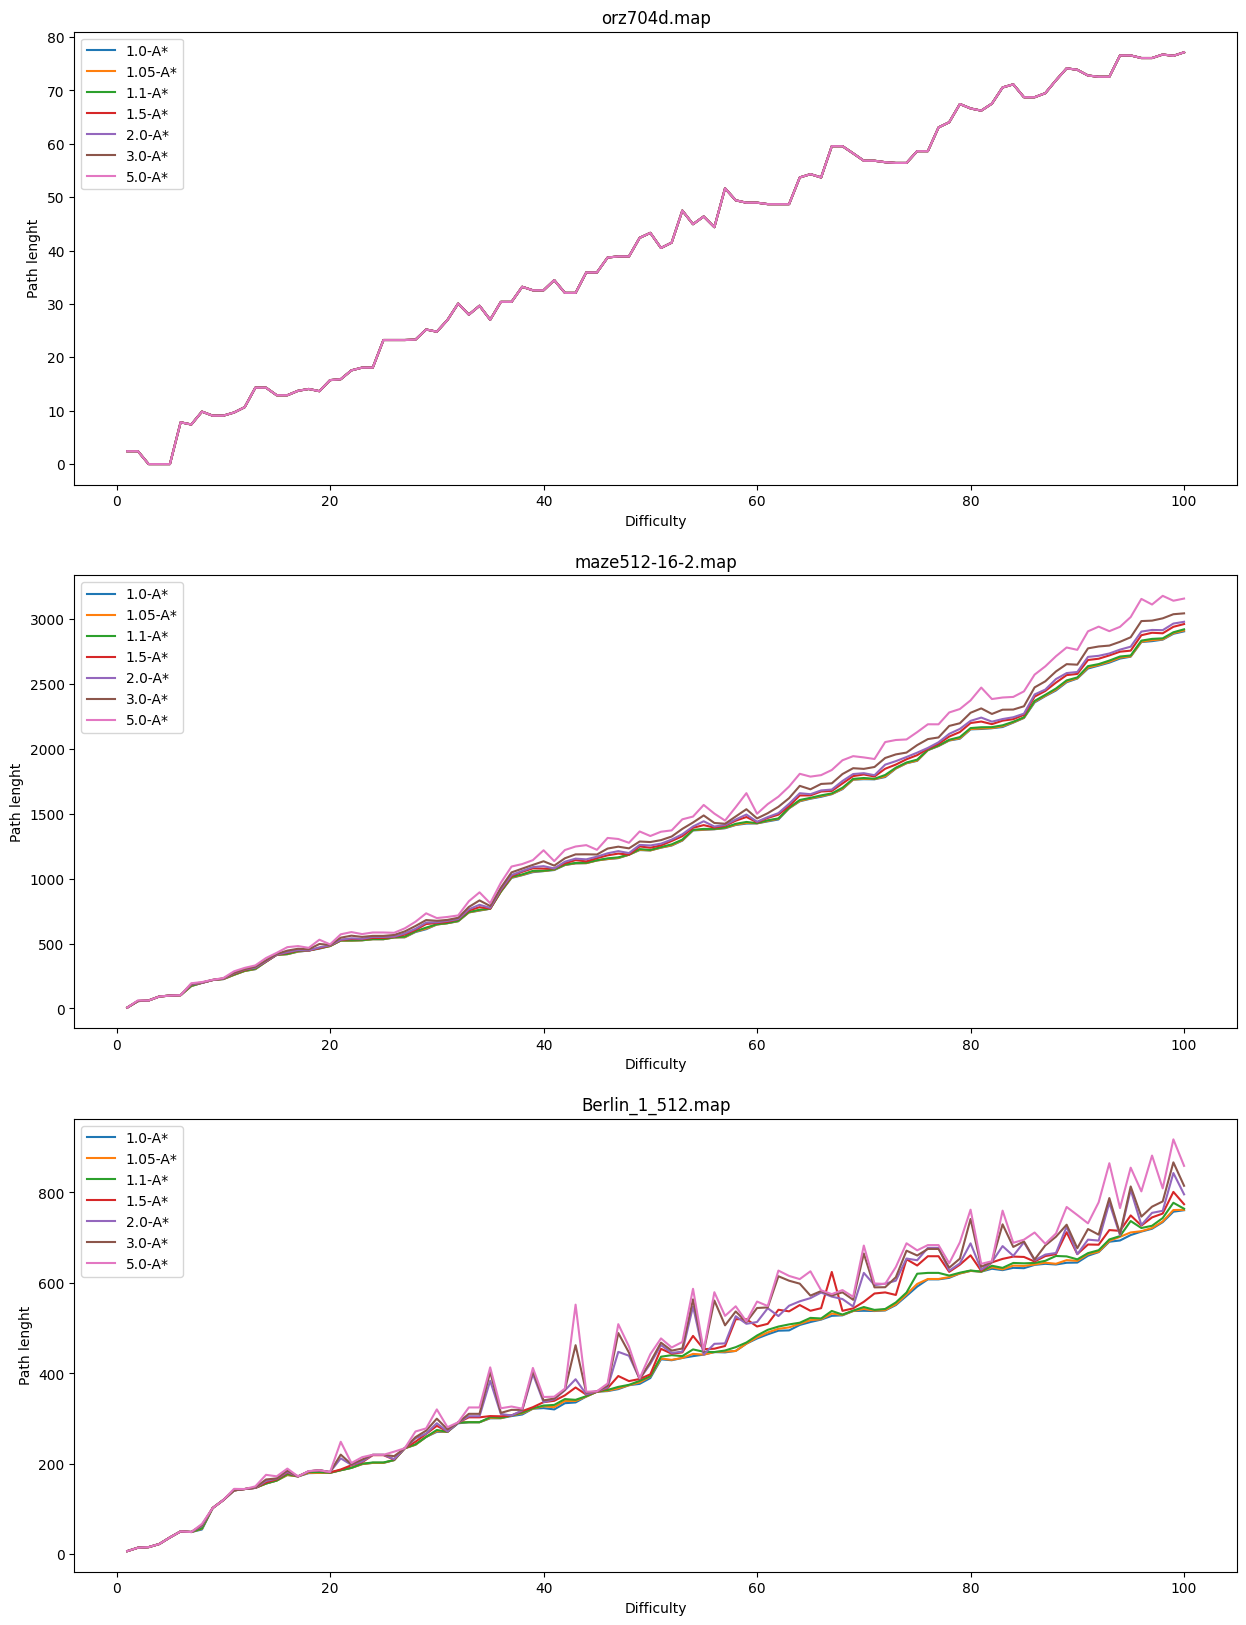

In [21]:
fig, ax = plt.subplots(3,1,figsize=(15,20))

x = [i for i in range(1, NUMBER_OF_TASKS+1)]

y_weights = {key: [] for key in wastar_statistic.keys()}
map_names = []

for i in range(NUMBER_OF_TRIALS):
    for w in y_weights.keys():
        y_weights[w].append(wastar_statistic[w][i]["len"])

        ax[i].plot(x, y_weights[w][i], label=f"{float(w)}-A*")
    
    ax[i].legend()
    
    ax[i].set_xlabel('Difficulty',fontsize = 10)
    ax[i].set_ylabel('Path lenght',fontsize = 10)
    map_names.append(wastar_statistic["1"][i]["map_name"][0])
    
    
ax[0].set_title(map_names[0])
ax[1].set_title(map_names[1])
ax[2].set_title(map_names[2])

plt.show()

### Число шагов


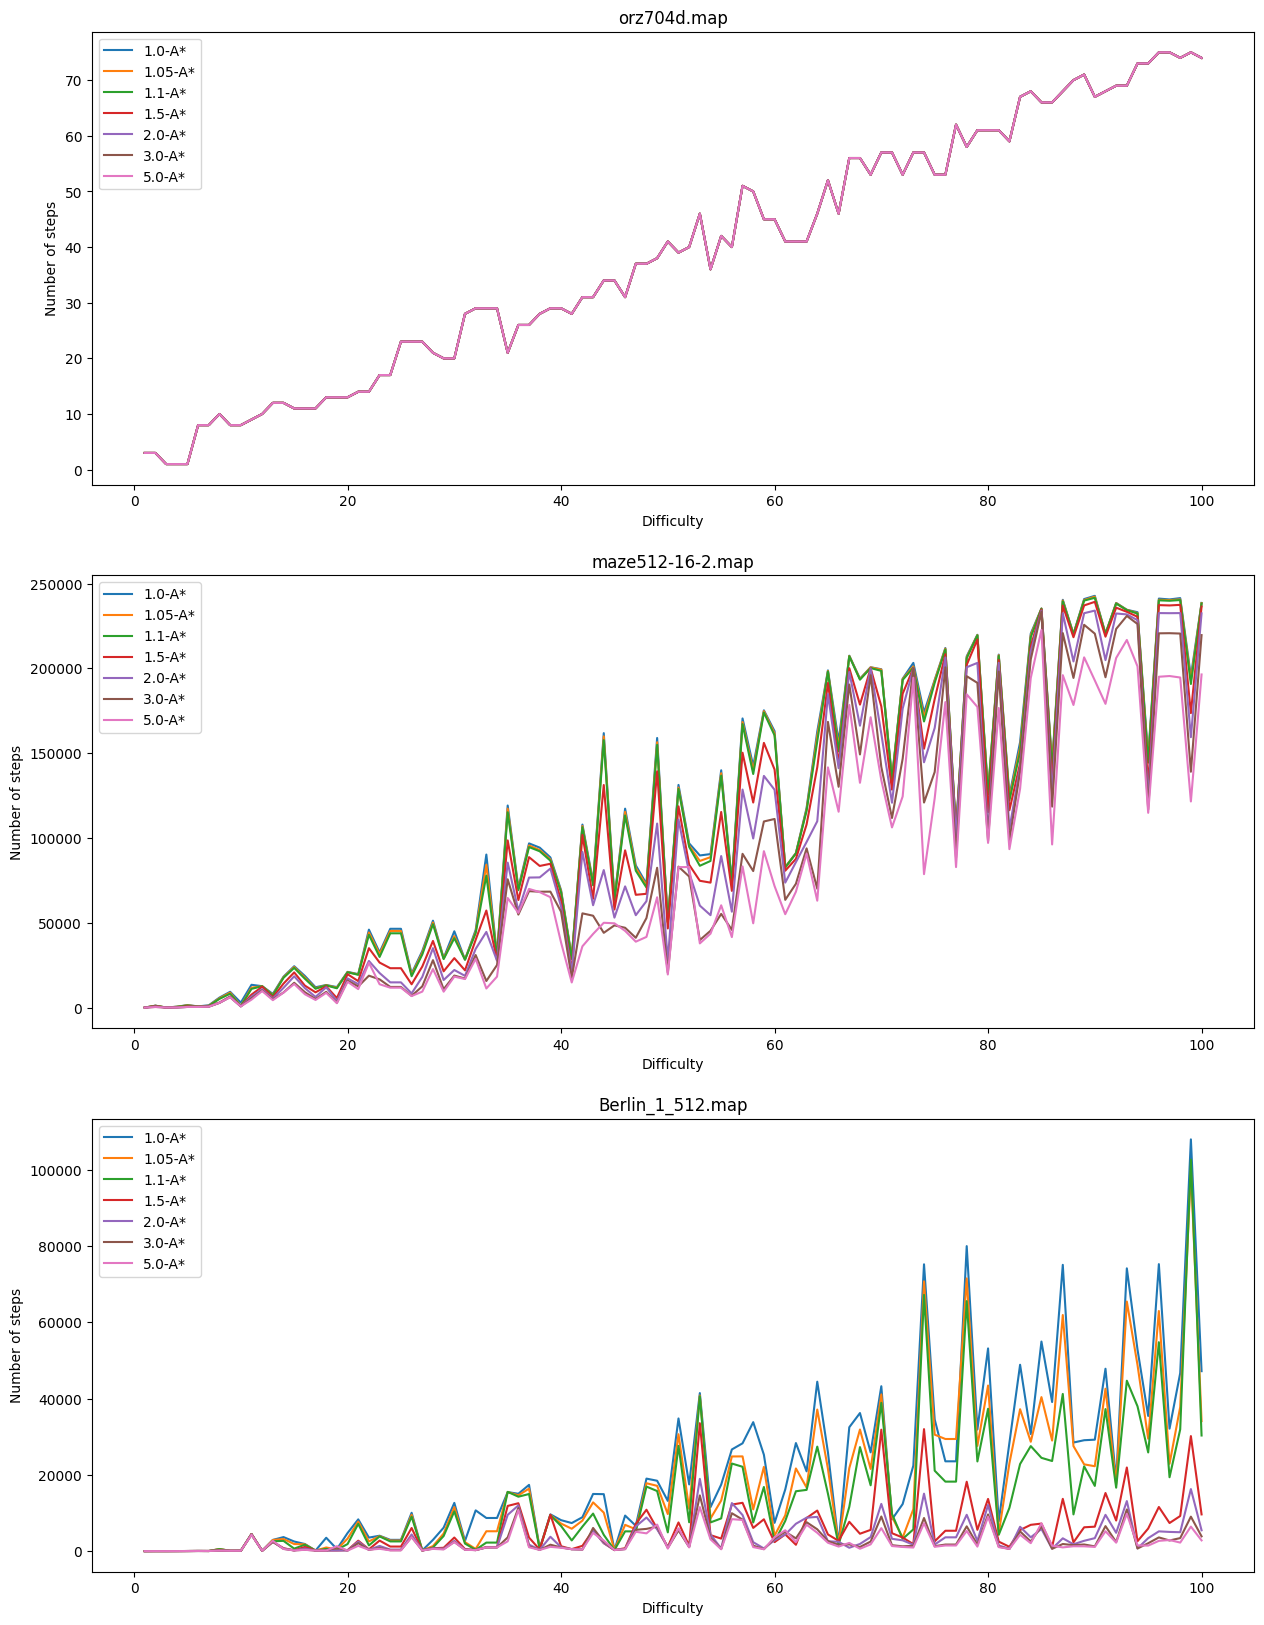

In [22]:
fig, ax = plt.subplots(3,1,figsize=(15,20))

x = [i for i in range(1, NUMBER_OF_TASKS+1)]

y_weights = {key: [] for key in wastar_statistic.keys()}
map_names = []

for i in range(NUMBER_OF_TRIALS):
    for w in y_weights.keys():
        y_weights[w].append(wastar_statistic[w][i]["steps"])

        ax[i].plot(x, y_weights[w][i], label=f"{float(w)}-A*")
    
    ax[i].legend()
    
    ax[i].set_xlabel('Difficulty',fontsize = 10)
    ax[i].set_ylabel('Number of steps',fontsize = 10)
    map_names.append(wastar_statistic["1"][i]["map_name"][0])
    
    
ax[0].set_title(map_names[0])
ax[1].set_title(map_names[1])
ax[2].set_title(map_names[2])

plt.show()

### Время исполнения

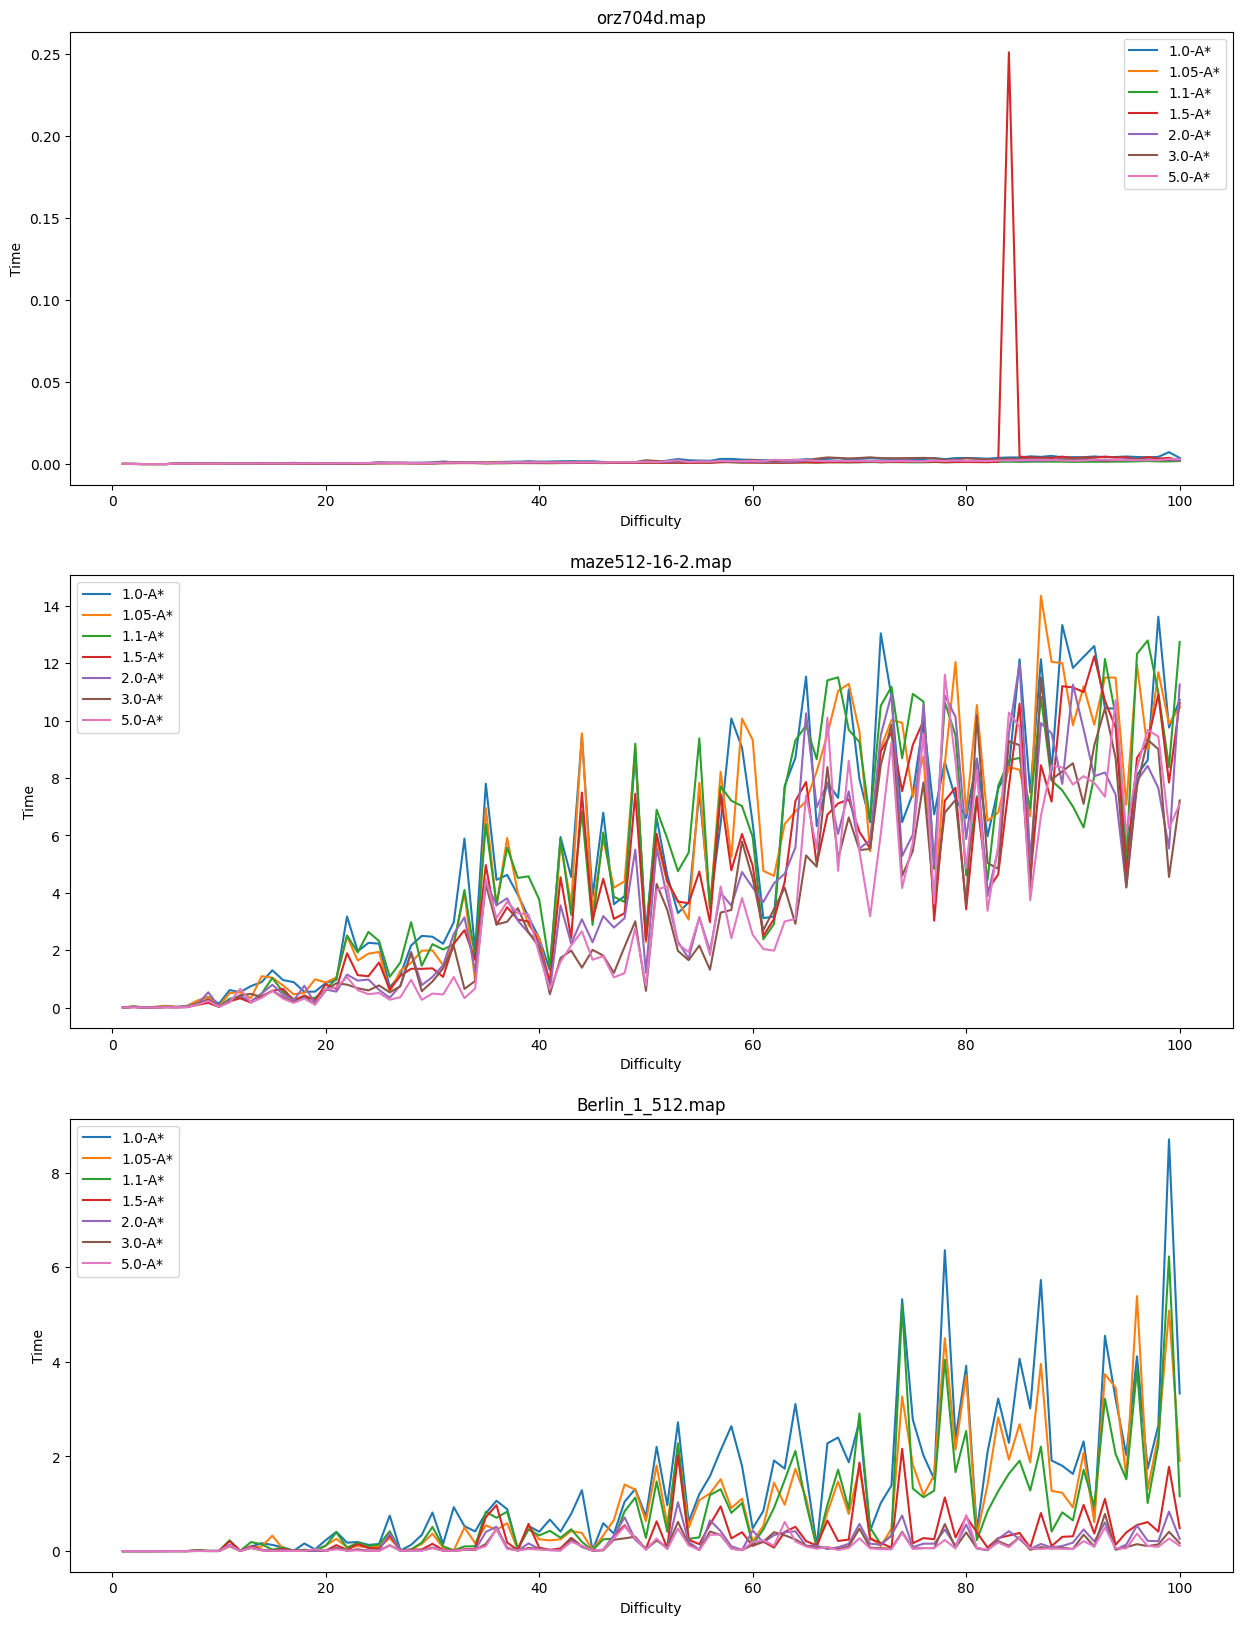

In [23]:
fig, ax = plt.subplots(3,1,figsize=(15,20))

x = [i for i in range(1, NUMBER_OF_TASKS+1)]

y_weights = {key: [] for key in wastar_statistic.keys()}
map_names = []

for i in range(NUMBER_OF_TRIALS):
    for w in y_weights.keys():
        y_weights[w].append(wastar_statistic[w][i]["time"])

        ax[i].plot(x, y_weights[w][i], label=f"{float(w)}-A*")
    
    ax[i].legend()
    
    ax[i].set_xlabel('Difficulty',fontsize = 10)
    ax[i].set_ylabel('Time',fontsize = 10)
    map_names.append(wastar_statistic["1"][i]["map_name"][0])

ax[0].set_title(map_names[0])
ax[1].set_title(map_names[1])
ax[2].set_title(map_names[2])

plt.show()

Результаты сравнительного анализа указывают на четкую корреляцию между значением веса, используемым в "неоптимальном" алгоритме A*, и временем выполнения. По мере увеличения значения веса вычислительная эффективность алгоритма улучшается, что приводит к сокращению времени выполнения. Эту корреляцию можно объяснить тем фактом, что более высокие значения веса отдают приоритет эвристической составляющей расчета стоимости, уменьшая количество развернутых узлов и, следовательно, уменьшая общее требуемое вычисление. Однако важно отметить, что увеличение значения веса также приводит к выбору неоптимальных или более длинных путей на "жестких" картах.

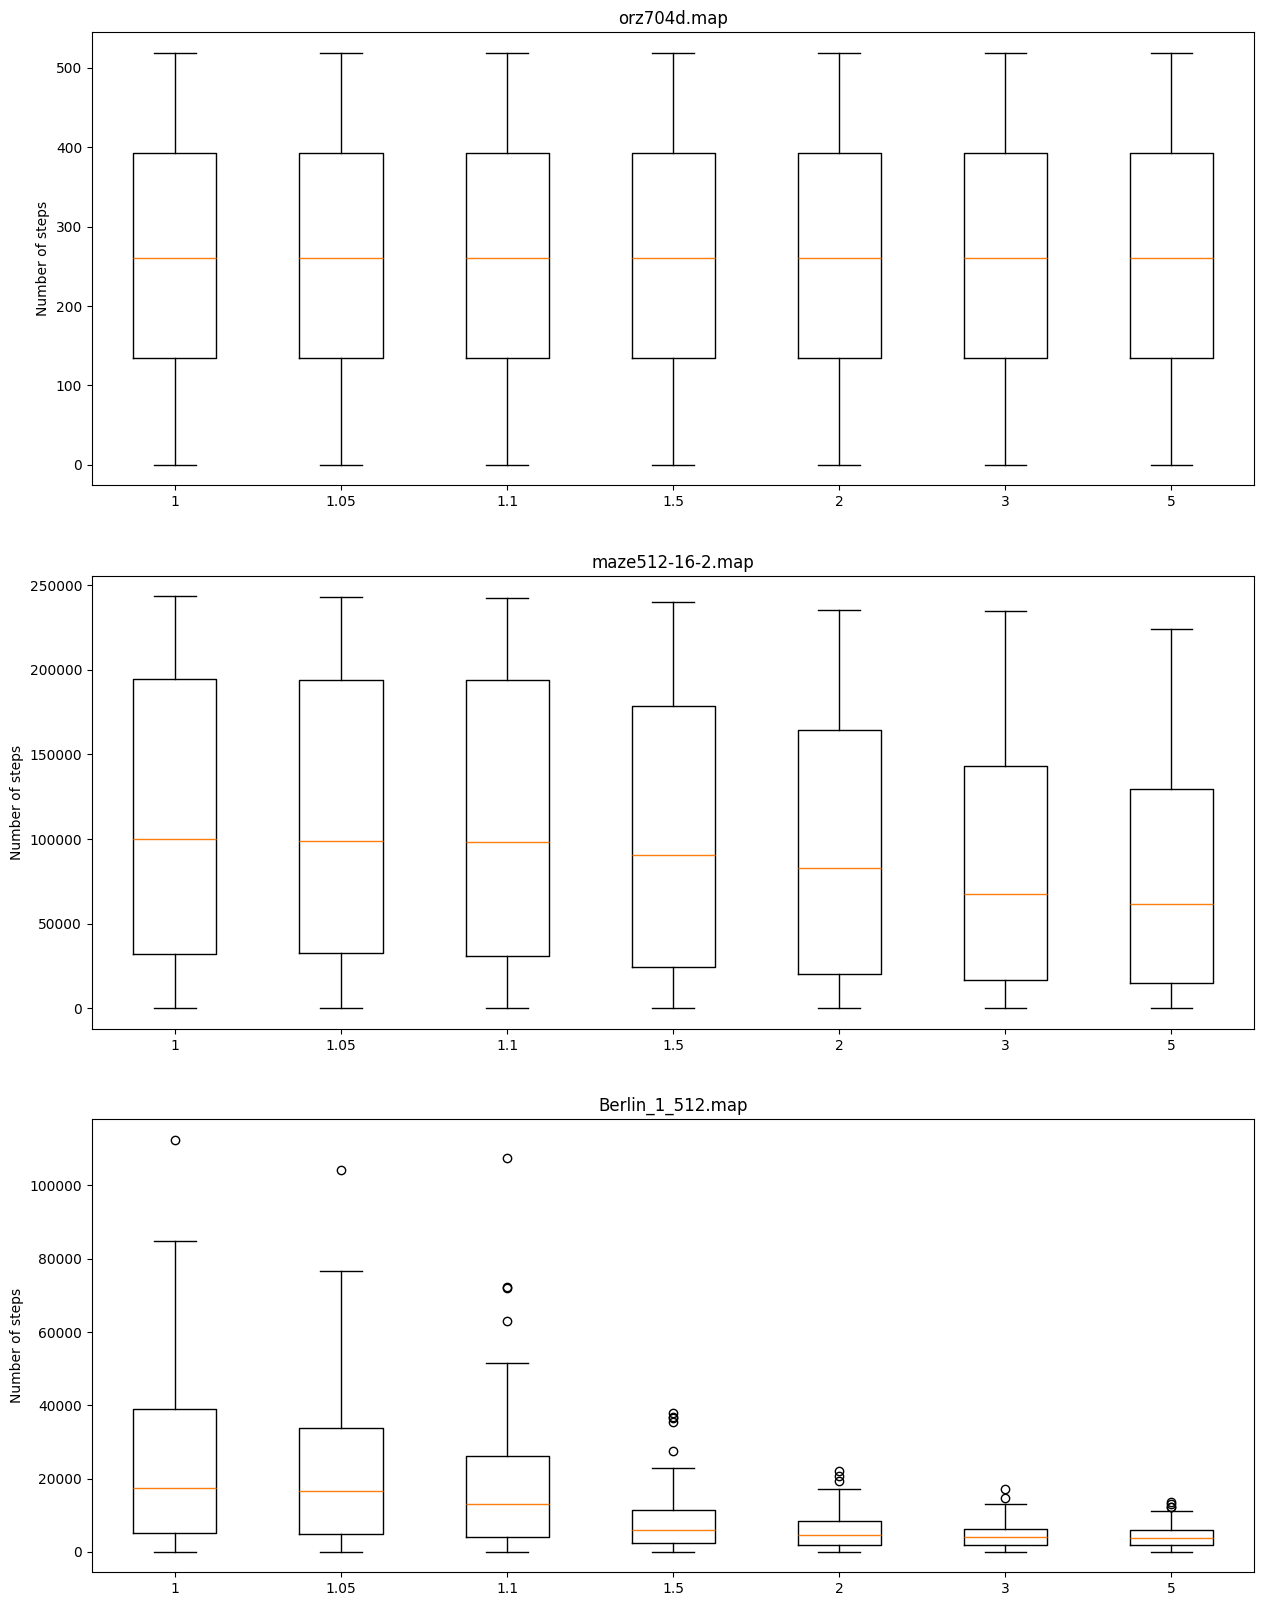

In [24]:
fig, ax = plt.subplots(3,1,figsize=(15,20))

y_weights = {key: [] for key in wastar_statistic.keys()}
map_names = []

for i in range(NUMBER_OF_TRIALS):
    for w in y_weights.keys():
        y_weights[w].append(wastar_statistic[w][i]["st_size"])
    
    ax[i].boxplot([y[i] for y in y_weights.values()]
                  , labels=y_weights.keys())
    
    ax[i].set_ylabel('Number of steps',fontsize = 10)
    map_names.append(wastar_statistic["1"][i]["map_name"][0])
    
ax[0].set_title(map_names[0])
ax[1].set_title(map_names[1])
ax[2].set_title(map_names[2])

plt.show()

### Выводы

**Плюсы:**
- Улучшенная вычислительная эффективность: использование значения веса в алгоритме A* может значительно сократить время выполнения за счет приоритета эвристического компонента расчета стоимости и сокращения количества развернутых узлов.
- Более быстрый поиск пути: при более высоких значениях веса алгоритм имеет тенденцию быстрее находить более короткие пути, что делает его пригодным для сценариев, где поиск оптимального пути не является основной задачей.

**Минусы:**
- Потенциальная неоптимальность: увеличение значения веса может привести к тому, что алгоритм выберет неоптимальные или более длинные пути. Это может быть недостатком в сценариях, где поиск оптимального пути имеет решающее значение.
- Компромисс оптимальности пути: достижение правильного баланса между вычислительной эффективностью и оптимальностью пути может быть сложной задачей, поскольку более высокие значения веса повышают эффективность, но могут понизить качество пути.
- Зависит от сценария: эффективность взвешенного алгоритма A* зависит от конкретного сценария поиска пути, и для определения подходящего значения веса требуется тщательное рассмотрение.
